# PINN for PDE

This notebook is based on [googlecolab](https://colab.research.google.com/github/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb) version of [original work](https://github.com/maziarraissi/PINNs)

Referenses:

- Maziar Raissi, Paris Perdikaris, George Em Karniadakis. *Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations*. [arXiv 1711.10561](https://arxiv.org/abs/1711.10561) 
- Maziar Raissi, Paris Perdikaris, George Em Karniadakis. *Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations*. [arXiv 1711.10566](https://arxiv.org/abs/1711.10566) 
- Maziar Raissi, Paris Perdikaris, George Em Karniadakis. *Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations*. J. Comp. Phys. 378 pp. 686-707 [DOI: 10.1016/j.jcp.2018.10.045](https://www.sciencedirect.com/science/article/pii/S0021999118307125) 

## Transport Equation

Considered a simple 1-d transport equation

$$
\begin{align}
   \frac{\partial u (t,x)}{\partial t} + c \frac{\partial u(t,x)}{\partial x} & = 0, \quad & &(t,x) \in [0,T) \times [-1,1],\\
   u(0,x) &= \tanh \left( 10x \right)+1/2, \quad & & x \in [-1,1],\\
   u(t,-1) &= 1, \quad & & t \in [0,T)\\
   u(t,1)  &= 0, \quad & & t \in [0,T).
\end{align}
$$

Propose that $c$ is constant, then analitical solution is:


$$u(t,x)=\psi_0(x-ut) = \tanh((x-t) \cdot 10)+1)/2$$

but... in general, $u(t,x)$ is unknown.

Main aim is in founding of $u$. Lets propouse that $u$ can be represented by neural network with $tanh$ activation function:

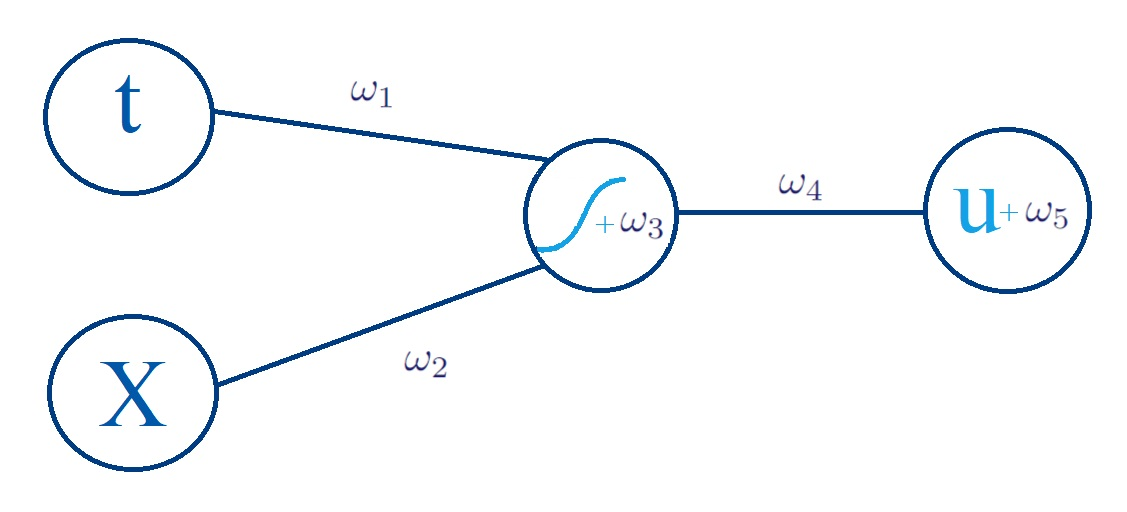

It means that desired function $u(t,x)$ looks for kind of

$$\hat{u}(t,x) = \tanh(x \cdot \omega_2 + t\cdot \omega_1+\omega_3)\cdot \omega_4+\omega_5$$

One can propose another kind of function for example:

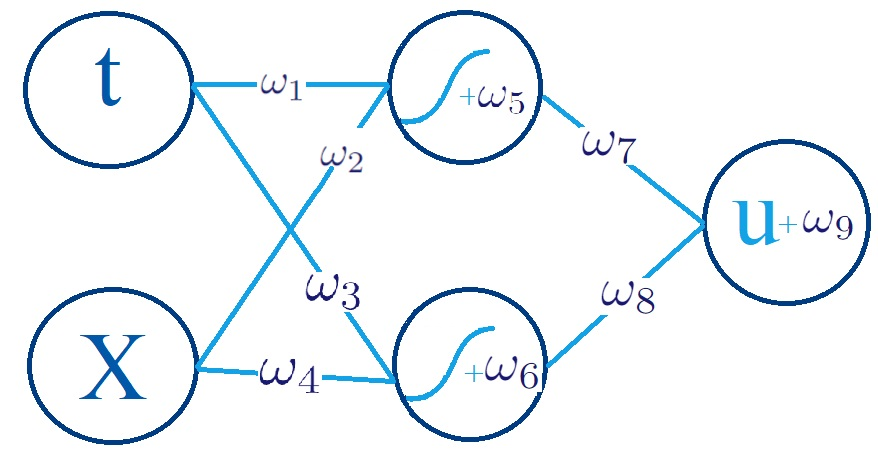

And this picture means that $u(t,x)$ has kind of

$$\hat{u}(t,x) = \tanh(x \cdot \omega_2 + t\cdot \omega_1+\omega_5)\cdot \omega_7+ \tanh(x \cdot \omega_4 + t\cdot \omega_3+\omega_6)\cdot \omega_8 +\omega_9$$ 

Or one more representation of $u(t,x)$:


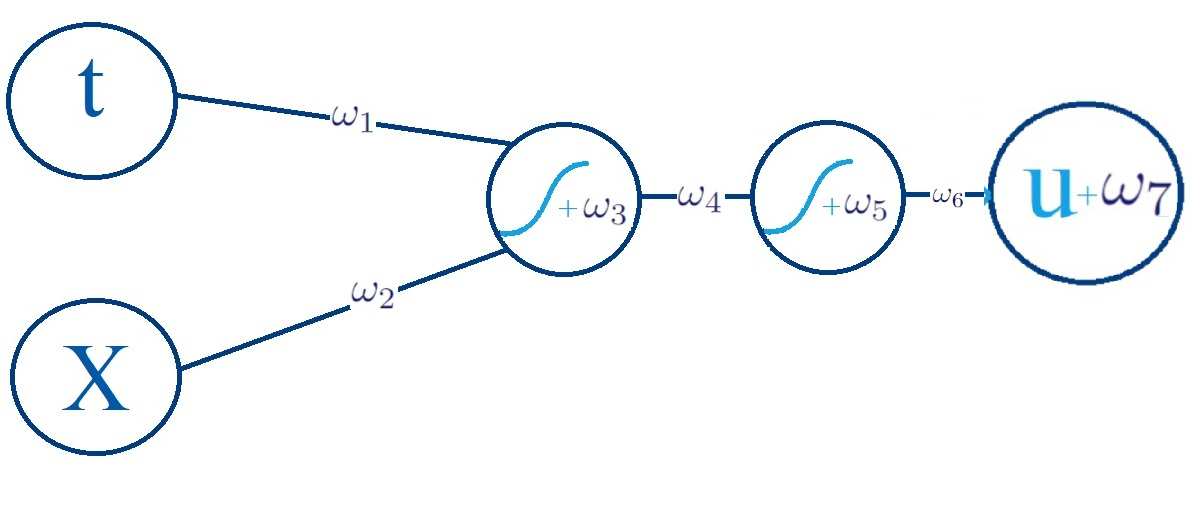

$$\hat{u}(t,x) = \tanh(\tanh(x \cdot \omega_2 + t\cdot \omega_1+\omega_3)\cdot \omega_4+\omega_5)\cdot \omega_6+\omega_7$$  


In [3]:
import tensorflow as tf
import numpy as np

DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

In [4]:
# Определяем архитектуру модели
class PINN_NeuralNet(tf.keras.Model):
    """ Базовая архитектура PINN модели."""

    def __init__(self, tmin, tmax, xmin, xmax,
            output_dim=1,
            num_hidden_layers=8, 
            num_neurons_per_layer=20,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)
        
        # Нижняя граница
        lb = tf.constant([tmin, xmin], dtype=DTYPE)
        # Верхняя граница
        ub = tf.constant([tmax, xmax], dtype=DTYPE)
        
        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub
        
        # Define NN architecture
        self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)
        
    def call(self, X):
        """Прямой проход через нейронную сеть."""
        Z = self.scale(X)
        for i in range(self.num_hidden_layers):
            X = self.hidden[i](X)
        return self.out(X)

In [20]:
import scipy.optimize
import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


class PINNSolver():
    def __init__(self, model,u, N_0=50,N_b=50,N_r=10000):
        self.model = model
        
        # Набор точек
        #N_0 = 50 #На начальные условияФ
        #N_b = 50 #На граничные условия
        #N_r = 10000 #Внутренние точки

        # Закрепление состояния для воспроизведения результатов
        tf.random.set_seed(1)

        # Распределяем точки для начальных данных
        self.t_0 = tf.ones((N_0,1), dtype=DTYPE)*model.lb[0]
        self.x_0 = tf.random.uniform((N_0,1), model.lb[1], model.ub[1], dtype=DTYPE)
        self.X_0 = tf.concat([self.t_0, self.x_0], axis=1)

        # Определяем начальные условия для набора данных x_0
        self.psi_0 = self.fun_psi_0(self.x_0)

        # Граничные данные
        self.t_b = tf.random.uniform((N_b,1), model.lb[0], model.ub[0], dtype=DTYPE)
        self.x_b = model.lb[1] + (model.ub[1] - model.lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
        X_b = tf.concat([self.t_b, self.x_b], axis=1)

        # Определяем граничные данные
        self.psi_b = self.fun_psi_b(self.x_b)

        # Распределяем колокационные точки
        self.t_r = tf.random.uniform((N_r,1), model.lb[0], model.ub[0], dtype=DTYPE)
        self.x_r = tf.random.uniform((N_r,1), model.lb[1], model.ub[1], dtype=DTYPE)
        X_r = tf.concat([self.t_r, self.x_r], axis=1)
        
        # Собираем граничные и начальные данные в списокCollect boundary and inital data in lists
        self.X_data = [self.X_0, X_b]
        self.psi_data = [self.psi_0, self.psi_b]
        
        
        # Хранилище для точек колокации
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]
        self.u = u
        
        # Инициализация истории для функции потерь и счетчика глобальных итераций
        self.hist = []
        self.iter = 0
    
    def fun_psi_0(self,x):
        #return (np.tanh(x*10)+1)/2
        return (np.heaviside(x,1))
    
    def fun_psi_b(self, x):
        return (np.heaviside(x,1))
        #return (np.tanh(x*10)+1)/2
    
    
    def get_r(self):
        
        with tf.GradientTape(persistent=True) as tape:
            # Наблюдение за переменными которые будут участвовать в автоматическом дифференцировании
            tape.watch(self.t)
            tape.watch(self.x)
            
            # Вычисление текущих значений psi(t,x)
            psi = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))
            psi_x = tape.gradient(psi, self.x)
            
        psi_t = tape.gradient(psi, self.t)
        
        del tape
        
        return self.fun_r(self.t, self.x, psi_t, psi_x,self.u)
    
    def loss_fn(self,X,psi):
        
        # Вычисление функции потерь или невязки phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))
        
        # Инициализация функции потерь
        loss = phi_r

        # Добавляем начальные и граничные условия повышения функции потерь
        for i in range(len(X)):
            psi_pred = self.model(X[i])
            loss += tf.reduce_mean(tf.square(psi[i] - psi_pred))
        
        return loss
    
    def get_grad(self,X,psi):
        with tf.GradientTape(persistent=True) as tape:
            # Эти производные для обучаемых параметров
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X,psi)
            
        g = tape.gradient(loss, self.model.trainable_variables)
        del tape
        
        return loss, g
    
    def fun_r(self, t, x, psi_t, psi_x, u):
        """Невязка"""
        return psi_t + u * psi_x
    
    def solve_with_TFoptimizer(self, optimizer, N=1001):
        """ Оптимизация производится градиентным спуском."""
        
        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(self.X_data,self.psi_data)
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss
        
        for i in range(N):
            
            loss = train_step()
            
            self.current_loss = loss.numpy()
            self.callback()
            tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,verbose=1)
            tf.keras.callbacks.ModelCheckpoint(
                filepath='/common/home/ryazanov_d/tmp',
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True,
                verbose=1)

    def solve_with_ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        """ Этот меодо обеспечивает интерфейс для обучение
        с помощью функции из scipy.
        (Tensorflow 1.xx имел интерфейс для этого, но в Tensorflow 2.xx более не поддерживается.)
        Переопределение типов необходимо потому что scipy-процедуры написаны на фортране
        который требует 64-битных чисел вместо 32-битных."""
        
        def get_weight_tensor():
            """ Функция возвращает текущеие значения переменных модели
            как  1d тензор соотвествующей длинны."""
            
            weight_list = []
            shape_list = []
            
            # Цикл по всем переменным такие как матрица весов, ветора сдвигов и неизвестные параметры
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())
                
            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()
        
        def set_weight_tensor(weight_list):
            """ Функция, которая устанавливает список весов для переменных в модели."""
            idx = 0
            for v in self.model.variables:
                vs = v.shape
                
                # Матрица весов
                if len(vs) == 2:  
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw
                
                # Вектор сдвига
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]
                    
                # Переменные
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1
                    
                # Назначение переменных cast так как треуется конверсия типов данных
                v.assign(tf.cast(new_val, DTYPE))
        
        def get_loss_and_grad(w):
            """Функция, которая предоставляет текущие значение функцию потерь
            и градиент относительно обучаемых параметров в виде вектора.
            Это необходимо для минимизатора LBFGS от scipy."""
            
            # Обновление весов в модели
            set_weight_tensor(w)
            # Определение значений \phi и градиента \theta w
            loss, grad = self.get_grad(self.X_data,self.psi_data)
            
            # Хранение текущего значения функции потерь для колбэка
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss            
            
            # Сплющенные градиент
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())
            
            # Приведение списка к массиву
            grad_flat = np.array(grad_flat,dtype=np.float64)
            
            # Возвращаем значение и градиента и функции потерь
            return loss, grad_flat
        
        
        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       tol=1*np.finfo(float).eps,
                                       **kwargs)
        
    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
        self.hist.append(self.current_loss)
        self.iter+=1
        
    
    def plot_solution(self,title='Solution of All Time',time=600,space=600, **kwargs):
        
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], time+1)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], space+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        psipred = self.model(tf.cast(Xgrid,DTYPE))
        Psi = psipred.numpy().reshape(time+1,space+1)

        fig, ax = plt.subplots(figsize=(6, 3), constrained_layout=True)        
        plt.colorbar(ax.pcolormesh(Psi))
        fig.suptitle(title, fontsize=16)
        
        plt.show()
        return fig, ax
        
    def plot_moment(self,t,title='Moment plot',time=600,space=600,Analit=False, **kwargs):

        tspace = np.linspace(self.model.lb[0], self.model.ub[0], time+1)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], space+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        psipred = self.model(tf.cast(Xgrid,DTYPE))
        Psi = psipred.numpy().reshape(time+1,space+1)
        fig, ax = plt.subplots(figsize=(15, 10), constrained_layout=True) 
        fig.suptitle(title, fontsize=16)
        if Analit:
            psiTR = np.heaviside(X-T,0)
            PsiTR = psiTR.reshape(time+1,space+1)
            plt.plot(PsiTR[:,t,c='r')
        
               
        plt.plot(Psi[:,t])
        plt.grid()
        plt.show()
        return fig, ax
        
    def plot_loss_history(self,title='Loss History',ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        fig.suptitle(title, fontsize=16)
        return fig, ax
    
    def plot_train(self,title='Train Set'):
        fig,ax = plt.subplots(figsize=(9,6))
        sc = plt.scatter(self.t_0, self.x_0, c=self.psi_0, marker='X', vmin=-1, vmax=1)
        plt.scatter(self.t_b, self.x_b, c=self.psi_b, marker='X', vmin=-1, vmax=1)
        plt.scatter(self.t_r, self.x_r, c='r', marker='.', alpha=0.1)
        plt.xlabel('$t$')
        plt.colorbar(sc)
        plt.ylabel('$x$')
        fig.suptitle(title, fontsize=16)
        return fig, ax

In [21]:
import scipy.optimize
import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


class PINNSolverSmooth(PINNSolver):
      
    # Определение начальных условий
    def fun_psi_0(self,x):
        return (np.tanh((x)*10)+1)/2

    # Определение граничных условий
    def fun_psi_b(self, x):
        return (np.tanh((x)*10)+1)/2
    
    def plot_moment(self,t,title='Moment plot',time=600,space=600,Analit=False, **kwargs):

        tspace = np.linspace(self.model.lb[0], self.model.ub[0], time+1)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], space+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        psipred = self.model(tf.cast(Xgrid,DTYPE))
        Psi = psipred.numpy().reshape(time+1,space+1)
        fig, ax = plt.subplots(figsize=(15, 10), constrained_layout=True) 
        fig.suptitle(title, fontsize=16)
        if Analit:
            psiTR = (np.tanh((X-T)*10)+1)/2
            PsiTR = psiTR.reshape(time+1,space+1)
            plt.plot(PsiTR[:,t],c='r')
        
               
        plt.plot(Psi[:,t])
        plt.grid()
        plt.show()
        return fig, ax

B100I100In5000MScipyOptimizerIt50000Atanh
It 00000: loss = 3.45919132e-01
It 00050: loss = 7.76732401e-10

Computation time: 0.7033636569976807 seconds


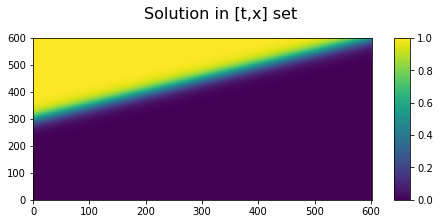

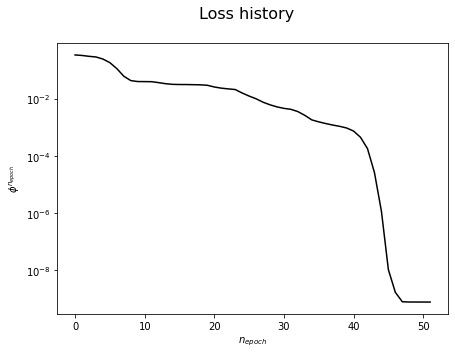

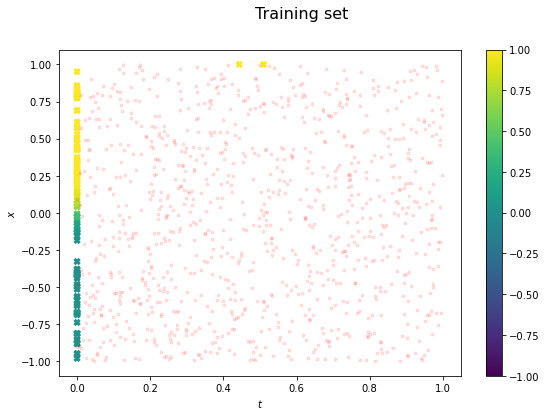

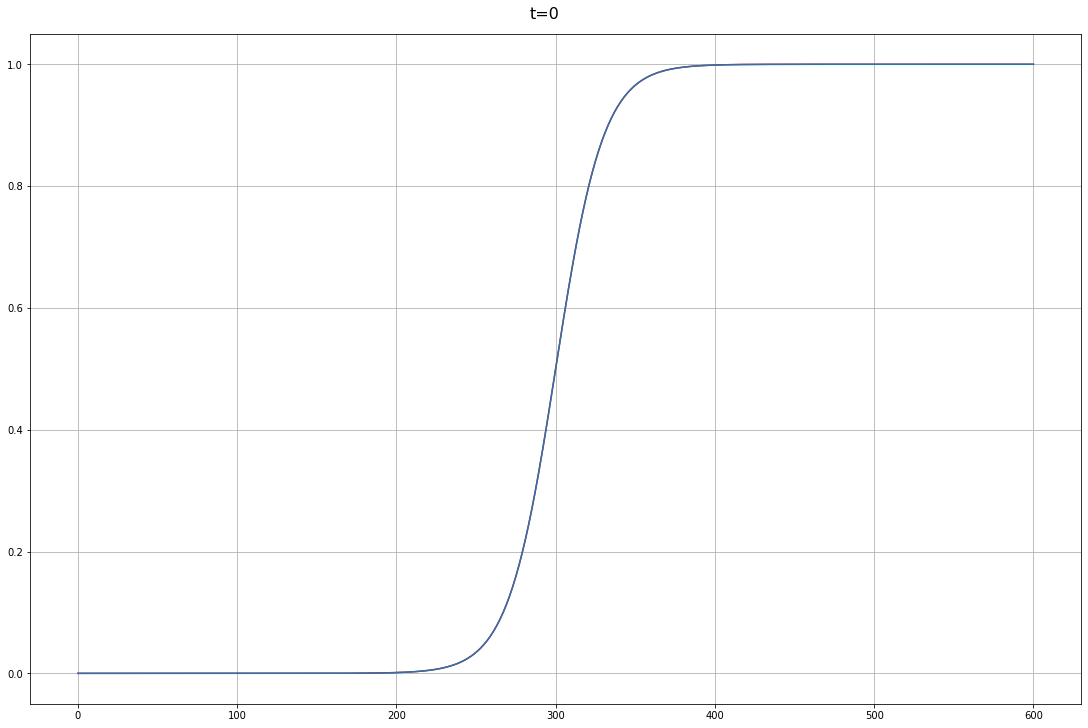

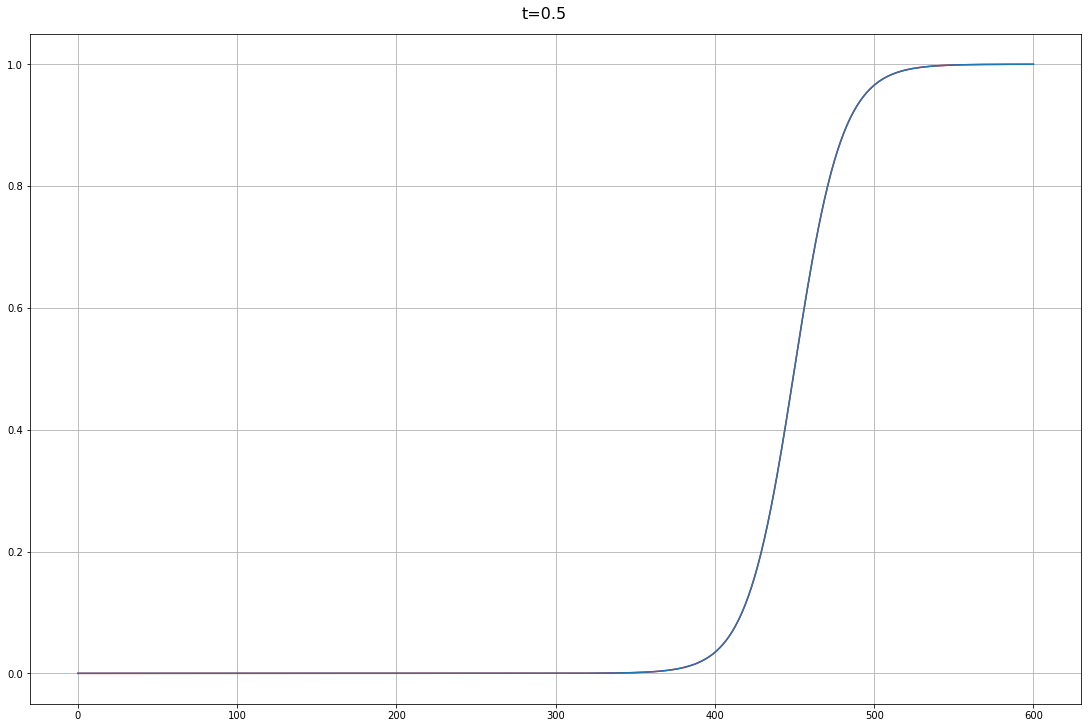

Model: "pinn__neural_net_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           multiple                  0         
                                                                 
 dense_4 (Dense)             multiple                  3         
                                                                 
 dense_5 (Dense)             multiple                  2         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
layer 0:  [[-9.99847 ]
 [ 9.999391]] [-3.7420647e-05]
layer 1:  [[0.50001293]] [0.5000119]


In [37]:
from time import time
u=1
Bound = [50]
Init = [50]
Intern = [1000,5000,10000]
mode = 'ScipyOptimizer'
IterationTF = [1000,5000,10000,50000]
A ='tanh'
It=1000
my_dict = {}
solver_dict = {}

x = 'B'+str(100)+'I'+str(100)+'In'+str(5000)+'M'+mode+'It'+str(50000)+'A'+'tanh'
print(x)
my_dict[x] = PINN_NeuralNet(0,1,-1,1,activation=A,num_hidden_layers=1,num_neurons_per_layer=1)
my_dict[x].build(input_shape=(None,2))
    
solver_dict[x] = PINNSolverSmooth(my_dict[x],u, N_0=100,N_b=2,N_r=1000)

t0=time()
    
if mode == 'TFoptimizer':
    # Выбор оптимизатора
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([10000,30000],[1e-2,1e-4,1e-7])
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    solver_dict[x].solve_with_TFoptimizer(optim, N=50000)

elif mode == 'ScipyOptimizer':
    solver_dict[x].solve_with_ScipyOptimizer(
    method='L-BFGS-B',
    options={'maxiter': 500000000,
                 'maxfun': 500000000,
                 'maxcor': 500,
                 'maxls': 500,
                 'ftol': 1e-30,
                 'gtol': 1e-30})

# Вывод времени вычисления
print('\nComputation time: {} seconds'.format(time()-t0))

solver_dict[x].plot_solution('Solution in [t,x] set');
solver_dict[x].plot_loss_history('Loss history');
solver_dict[x].plot_train('Training set');
solver_dict[x].plot_moment(0,'t=0',Analit=True);
solver_dict[x].plot_moment(300,'t=0.5',Analit=True);
my_dict[x].summary()
weights, biases = my_dict[x].layers[1].get_weights()
print("layer 0: ", weights, biases)
weights, biases = my_dict[x].layers[2].get_weights()
print("layer 1: ", weights, biases)